# Laboratorium 1

# NARZĘDZIE

### Konfiguracja

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax

    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
              
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [ ]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


# ROZWIĄZANIE

In [ ]:
import numpy as np
import pandas as pd

# Zadanie 1 i Zadanie 2 - przygotowanie zbiorów punktów i ich wizualizacja graficzna.

## Przygotowano następujące zbiory:

+ a) 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000],
+ b) 10^5 losowych punktów o współrzędnych z przedziału [-10^14, 10^14],
+ c) 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100,
+ d) 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez wektor (a, b), przyjmujemy a = [-1.0, 0.0], b = [1.0, 0.1].

## Zbiór A

<IPython.core.display.Javascript object>


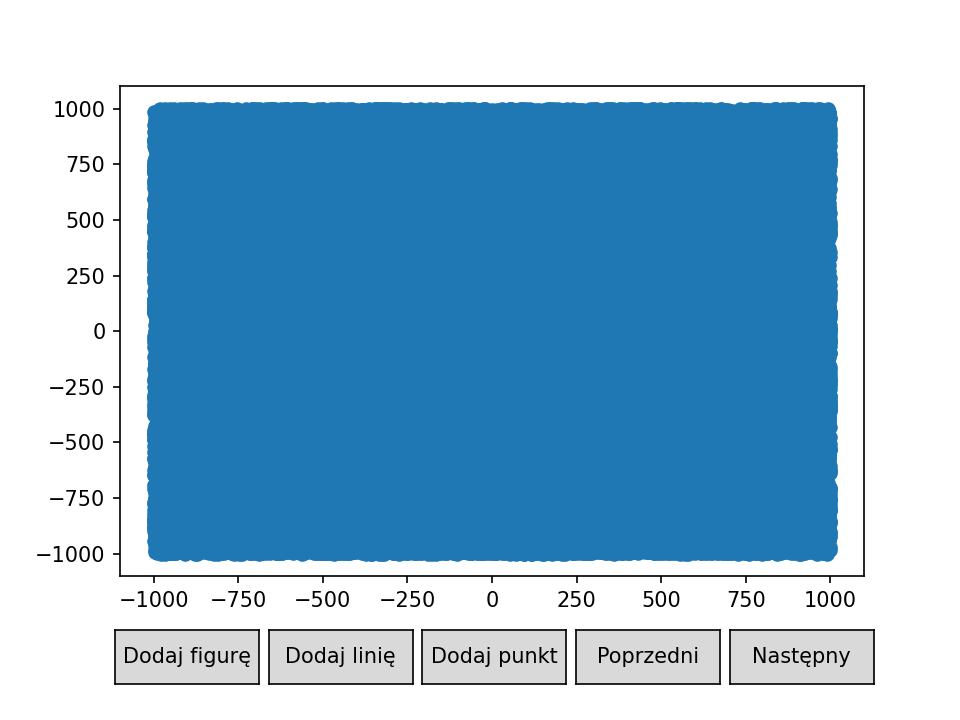

In [239]:
%matplotlib notebook
import random

random_points_a = [(random.uniform(-1000,1000), random.uniform(-1000,1000)) for _ in range(10**5)]

plot = Plot(points=[PointsCollection(random_points_a)])
plot.draw()

## Zbiór B

In [ ]:
%matplotlib notebook
import random

random_points_b = [(random.uniform(-10**14,10**14), random.uniform(-10**14,10**14)) for _ in range(10**5)]

plot = Plot(points=[PointsCollection(random_points_b)])
plot.draw()

## Zbiór C

In [ ]:
%matplotlib notebook
from math import sin, cos, pi
from random import random

random_points_c = []

for _ in range(1000):
    t = random() * (2*pi)
    radius = 100
    
    random_points_c.append((radius * sin(t), radius * cos(t)))

plot = Plot(points=[PointsCollection(random_points_c)])
plot.draw()

## Zbiór D

In [ ]:
%matplotlib notebook
import random

point_a = [-1.0, 0.0]
point_b = [1.0, 0.1]

random_points_d = []

coefficient_a = ( (point_b[1] - point_a[1]) / (point_b[0] - point_a[0]) )
coefficient_b = ( point_a[1] - coefficient_a * point_a[0] )

for _ in range(1000):
    x = random.uniform(-1000,1000)
    y = coefficient_a*x + coefficient_b
    random_points_d.append((x,y))
    
plot = Plot(points=[PointsCollection(random_points_d)])
plot.draw()

# Zadanie 3a - przygotowanie narzędzi

## Przygotowanie funkcji obliczających wyznaczniki 2x2 i 3x3

### Wyznacznik 3x3

In [ ]:
%matplotlib notebook

def det_3x3(a, b, c):
    return (a[0]*b[1] + b[0]*c[1] + c[0]*a[1] - b[1]*c[0] - c[1]*a[0] - a[1]*b[0])

    #a_x = a[0]
    #a_y = a[1]
    #b_x = b[0]
    #b_y = b[1]
    #c_x = c[0]
    #c_y = c[1]
    #
    #return (a_x*b_y + b_x*c_y + c_x*a_y - b_y*c_x - c_y*a_x - a_y*b_x)

### Wyznacznik 2x2

In [ ]:
%matplotlib notebook

def det_2x2(a, b, c):
    return ( ((a[0]-c[0]) * (b[1]-c[1])) - ((b[0]-c[0]) * (a[1]-c[1])) )

    #a_x = a[0]
    #a_y = a[1]
    #b_x = b[0]
    #b_y = b[1]
    #c_x = c[0]
    #c_y = c[1]
    #
    #return ( (a_x-c_x) * (b_y-c_y) - (b_x-c_x) * (a_y-c_y) )

### Biblioteczny wyznacznik 3x3

In [ ]:
%matplotlib notebook

import numpy as np

def det_3x3_lib(a, b, c):
    matrix_3x3 = np.array([[a[0], a[1], 1], 
                           [b[0], b[1], 1],
                           [c[0], c[1], 1]])
    
    return np.linalg.det(matrix_3x3)

### Biblioteczny wyznacznik 2x2

In [ ]:
%matplotlib notebook

import numpy as np

def det_2x2_lib(a, b, c):
    matrix_2x2 = np.array([[a[0]-c[0], a[1]-c[1]],
                           [b[0]-c[0], b[1]-c[1]]])
    
    return np.linalg.det(matrix_2x2)

## Przygotowanie programu, który dla każdego ze zbioru danych dokona podziału punktów względem ich orientacji w stosunku do odcinka ab 
Odcinek ab: ( a = [-1.0, 0.0], b = [1.0, 0.1] ).
Podział punktów na punkty znajdujące się po lewej stronie, po prawej stronie oraz współliniowe.

### Funkcja klasyfikująca punkty w zbiorze

In [ ]:
%matplotlib notebook

def classify_orient(points, det_func, epsilon):
    #LEFT - CCW => DET>0
    #RIGHT - CW => DET<0
    #COLLINEAR => DET=0
    
    a = (-1.0, 0.0)
    b = (1.0, 0.1)
    
    answear = {
        'left'     :[],
        'right'    :[],
        'collinear':[]
    }

    for point in points:
        det = det_func(a, b, point)
        
        if det < -epsilon:
            answear['right'].append(point)
        elif det > epsilon:
            answear['left'].append(point)
        else:
            answear['collinear'].append(point)
            
    return answear

### Funkcja prezentująca rozwiązanie rozwiązanie

In [632]:
%matplotlib notebook

def result(points, det_func, epsilon):
    classified = classify_orient(points, det_func, epsilon)

    plot = Plot(points=[
        PointsCollection(classified['left'], color='orange', marker="o"),
        PointsCollection(classified['right'], color='deepskyblue', marker="o"),
        PointsCollection(classified['collinear'], color='red', marker='o')]) #marker='.'
    
    plot.draw()
    
    for key, val in classified.items():
        print(key.capitalize(), ": ", len(classified[key]), sep="")  

# Zadanie 3b - podział punktów w zbiorach za pomocą przygotowanych narzędzi dla różnych tolerancji

## Przygotowanie różnych wartości epsilon

In [ ]:
epsilon0 = 0
epsilon1 = 10**-10
epsilon2 = 10**-12
epsilon3 = 10**-14
epsilon4 = 10**-16

## Zbiór A

### epsilon = 10^-10

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_a, det_2x2, epsilon1)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_a, det_3x3, epsilon1)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_a, det_2x2_lib, epsilon1)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_a, det_3x3_lib, epsilon1)

### epsilon = 10^-12

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_a, det_2x2, epsilon2)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_a, det_3x3, epsilon2)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_a, det_2x2_lib, epsilon2)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_a, det_3x3_lib, epsilon2)

### epsilon = 10^-14

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_a, det_2x2, epsilon3)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_a, det_3x3, epsilon3)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_a, det_2x2_lib, epsilon3)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_a, det_3x3_lib, epsilon3)

### epsilon = 10^-16

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_a, det_2x2, epsilon4)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_a, det_3x3, epsilon4)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_a, det_2x2_lib, epsilon4)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_a, det_3x3_lib, epsilon4)

## Zbiór B

### epsilon = 10^-10

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

<IPython.core.display.Javascript object>


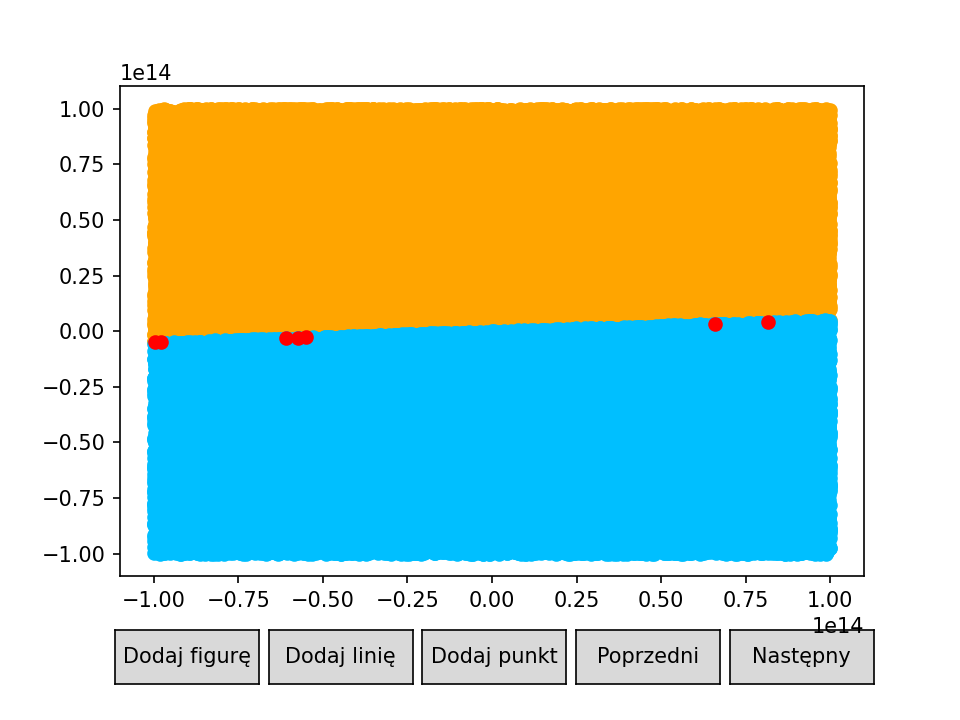

Left: 49960
Right: 50033
Collinear: 7


In [633]:
%matplotlib notebook

result(random_points_b, det_2x2, epsilon1)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_b, det_3x3, epsilon1)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_b, det_2x2_lib, epsilon1)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_b, det_3x3_lib, epsilon1)

### epsilon = 10^-12

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_b, det_2x2, epsilon2)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_b, det_3x3, epsilon2)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_b, det_2x2_lib, epsilon2)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_b, det_3x3_lib, epsilon2)

### epsilon = 10^-14

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_b, det_2x2, epsilon3)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_b, det_3x3, epsilon3)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_b, det_2x2_lib, epsilon3)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_b, det_3x3_lib, epsilon3)

### epsilon = 10^-16

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_b, det_2x2, epsilon4)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_b, det_3x3, epsilon4)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_b, det_2x2_lib, epsilon4)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_b, det_3x3_lib, epsilon4)

## Zbiór C

### epsilon = 10^-10

In [ ]:
#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_c, det_2x2, epsilon1)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_c, det_3x3, epsilon1)

In [ ]:
#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_c, det_2x2_lib, epsilon1)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_c, det_3x3_lib, epsilon1)

### epsilon = 10^-12

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_c, det_2x2, epsilon2)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_c, det_3x3, epsilon2)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_c, det_2x2_lib, epsilon2)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_c, det_3x3_lib, epsilon2)

### epsilon = 10^-14

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_c, det_2x2, epsilon3)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_c, det_3x3, epsilon3)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_c, det_2x2_lib, epsilon3)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_c, det_3x3_lib, epsilon3)

### epsilon = 10^-16

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_c, det_2x2, epsilon4)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_c, det_3x3, epsilon4)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_c, det_2x2_lib, epsilon4)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_c, det_3x3_lib, epsilon4)

## Zbiór D

In [ ]:
### 1. epsilon = 10^-10

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_d, det_2x2, epsilon1)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_d, det_3x3, epsilon1)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_d, det_2x2_lib, epsilon1)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_d, det_3x3_lib, epsilon1)

### 2. epsilon = 10^-12

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_d, det_2x2, epsilon2)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_d, det_3x3, epsilon2)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_d, det_2x2_lib, epsilon2)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_d, det_3x3_lib, epsilon2)

### 3. epsilon = 10^-14

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_d, det_2x2, epsilon3)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_d, det_3x3, epsilon3)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_d, det_2x2_lib, epsilon3)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_d, det_3x3_lib, epsilon3)

### 4. epsilon = 10^-16

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 2x2

In [ ]:
%matplotlib notebook

result(random_points_d, det_2x2, epsilon4)

#### Obliczenia wykonane za pomocą przygotowanego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_d, det_3x3, epsilon4)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 2x2¶

In [ ]:
%matplotlib notebook

result(random_points_d, det_2x2_lib, epsilon4)

#### Obliczenia wykonane za pomocą bibliotecznego wyznacznika 3x3

In [ ]:
%matplotlib notebook

result(random_points_d, det_3x3_lib, epsilon4)

# Zadanie 4

## Przygotowanie narzędzia znajdującego i zliczającego różnice w klasyfikacjach zbiorów

In [ ]:
def unify_result(result):
    sorted_result = [[x, 'c'] for x in result['collinear']]
    sorted_result.extend([[x, 'l'] for x in result['left']])
    sorted_result.extend([[x, 'r'] for x in result['right']])
    
    return sorted_result

In [ ]:
def diff(points, e1, e2, det1, det2):
    diff_tab = []
    
    res1 = classify_orient(points, det1, e1)
    res2 = classify_orient(points, det2, e2)
    
    res1 = sorted(unify_result(res1))
    res2 = sorted(unify_result(res2))
    
    for i in range(len(points)):
        if res1[i] != res2[i]:
            diff_tab.append(res1[i][0])
                
    return diff_tab

#%matplotlib notebook
#Plot(points=[PointsCollection(diff(POINTS, EPSILON, DET1, DET2))]).draw()

## Graficznie różnice w podziale punktów dla różnych wartości epsilon i różnych sposobów liczenia wartości wyznacznika

### Zbiór A

In [ ]:
print(len(diff(random_points_a, 0.1, 10**-5, det_2x2, det_2x2_lib)))

In [ ]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_a, 0.1, 10**-5, det_2x2, det_2x2_lib))])
plot.draw()

### Zbiór B

In [ ]:
print(len(diff(random_points_b, epsilon1, epsilon1, det_2x2, det_2x2_lib)))

In [ ]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_b, epsilon1, epsilon1, det_2x2, det_2x2_lib))])
plot.draw()

### Zbiór C

In [ ]:
print(len(diff(random_points_c, epsilon1, epsilon1, det_2x2, det_2x2_lib)))

In [ ]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_c, 5, 10**-5, det_2x2, det_3x3_lib))])
plot.draw()

### Zbiór D

In [ ]:
print(len(diff(random_points_d, epsilon1, epsilon1, det_2x2, det_2x2_lib)))

In [ ]:
print(len(diff(random_points_d, epsilon2, epsilon2, det_2x2, det_2x2_lib)))

In [ ]:
print(len(diff(random_points_d, epsilon3, epsilon3, det_2x2, det_2x2_lib)))

In [ ]:
print(len(diff(random_points_d, epsilon4, epsilon4, det_2x2, det_2x2_lib)))

In [ ]:
print(len(diff(random_points_d, epsilon1, epsilon1, det_3x3, det_3x3_lib)))

In [ ]:
print(len(diff(random_points_d, epsilon2, epsilon2, det_3x3, det_3x3_lib)))

In [ ]:
print(len(diff(random_points_d, epsilon3, epsilon3, det_3x3, det_3x3_lib)))

In [ ]:
print(len(diff(random_points_d, epsilon4, epsilon4, det_3x3, det_3x3_lib)))

In [ ]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_d, epsilon3, epsilon3, det_2x2, det_2x2_lib))])
plot.draw()

In [ ]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_d, epsilon4, epsilon4, det_2x2, det_2x2_lib))])
plot.draw()

In [ ]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_d, epsilon3, epsilon3, det_3x3, det_3x3_lib))])
plot.draw()

In [ ]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_d, epsilon3, epsilon3, det_3x3, det_3x3_lib))])
plot.draw()

In [ ]:
# Zadanie 5

In [ ]:
from time import time

start = time()
classify_orient(random_points_b, det_2x2, epsilon3)
stop = time()
print("2x2:", stop - start)

start = time()
classify_orient(random_points_b, det_2x2_lib, epsilon3)
stop = time()
print("2x2_lib:", stop - start)

start = time()
classify_orient(random_points_b, det_3x3, epsilon3)
stop = time()
print("3x3:", stop - start)

start = time()
classify_orient(random_points_b, det_3x3_lib, epsilon3)
stop = time()
print("3x3_lib:", stop - start)

## Wnioski

<IPython.core.display.Javascript object>


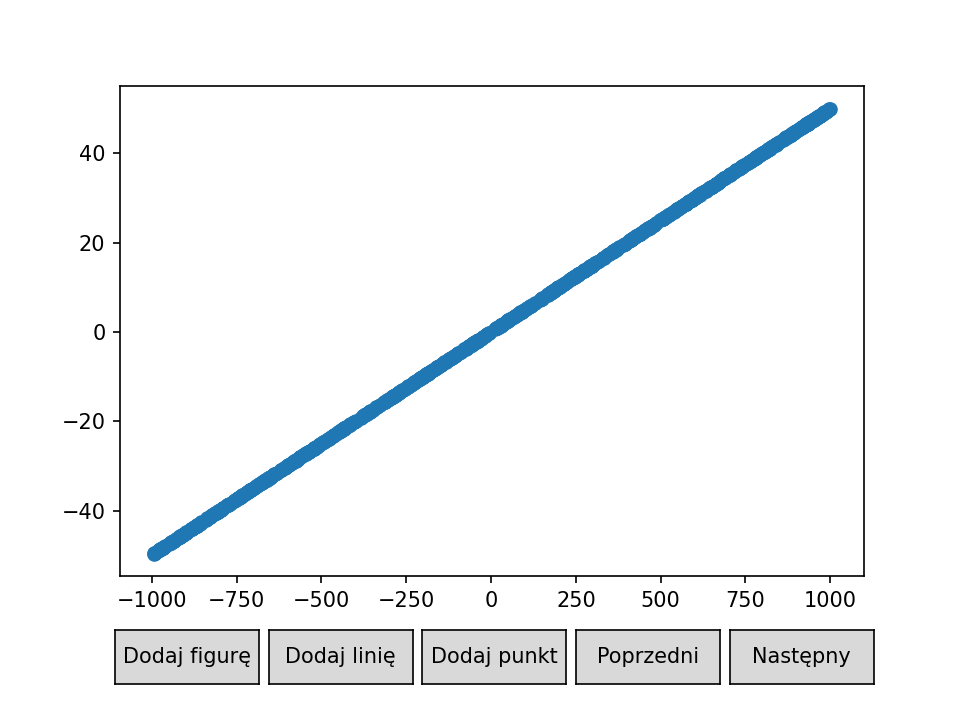

In [628]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_d, epsilon4, epsilon4, det_2x2, det_2x2_lib))])
plot.draw()

<IPython.core.display.Javascript object>


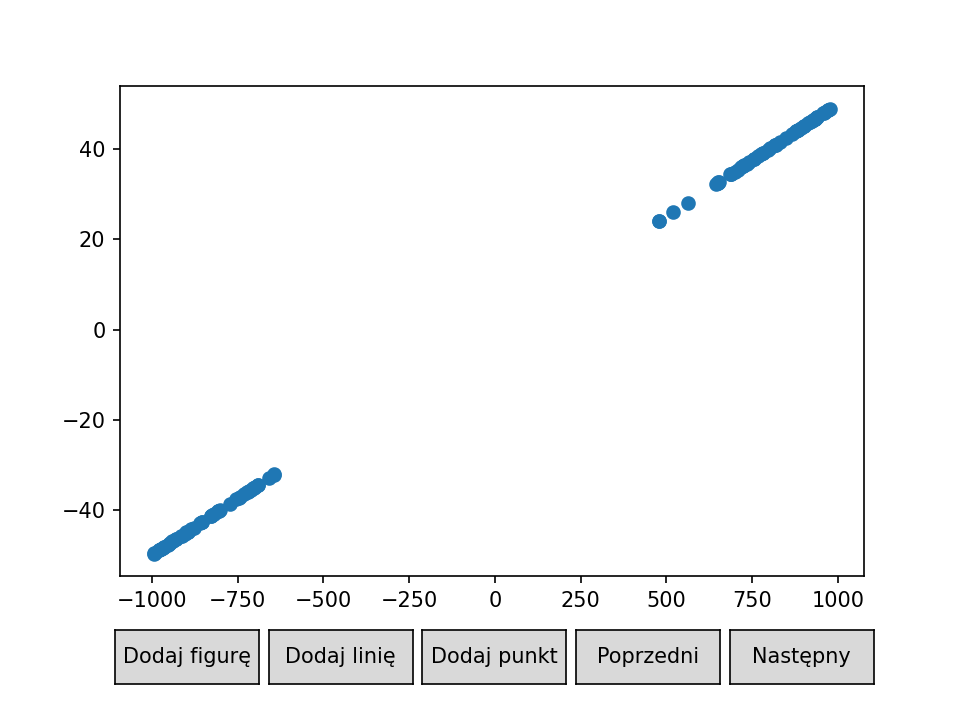

In [629]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_d, epsilon3, epsilon3, det_3x3, det_3x3_lib))])
plot.draw()

<IPython.core.display.Javascript object>


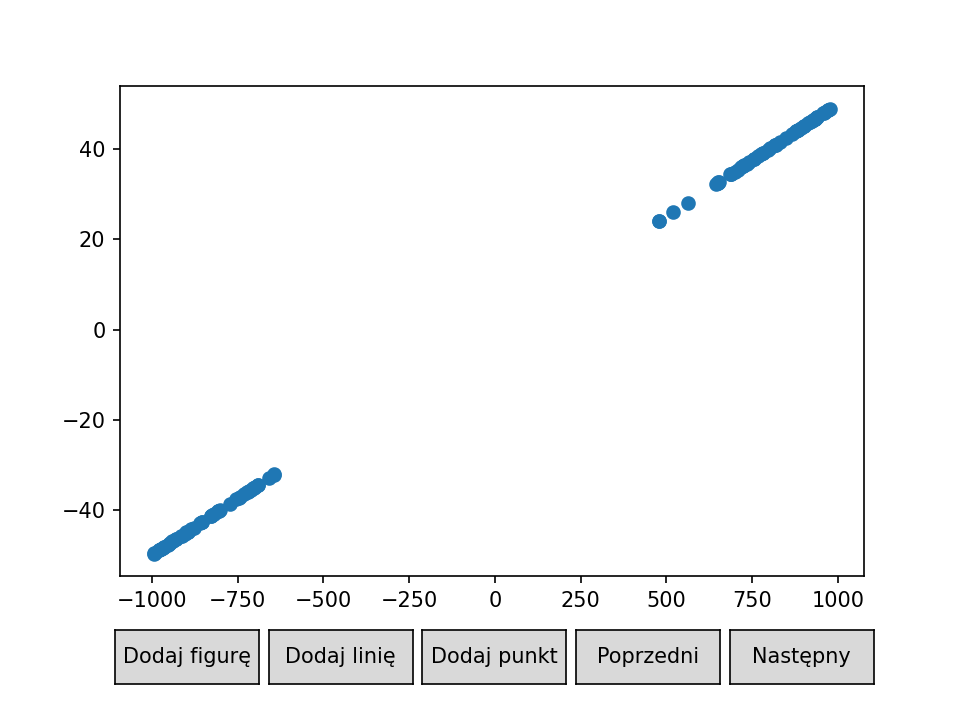

In [630]:
%matplotlib notebook

plot = Plot(points=[PointsCollection(diff(random_points_d, epsilon3, epsilon3, det_3x3, det_3x3_lib))])
plot.draw()

# Zadanie 5

In [ ]:
from time import time

start = time()
classify_orient(random_points_b, det_2x2, epsilon3)
stop = time()
print("2x2:", stop - start)

start = time()
classify_orient(random_points_b, det_2x2_lib, epsilon3)
stop = time()
print("2x2_lib:", stop - start)

start = time()
classify_orient(random_points_b, det_3x3, epsilon3)
stop = time()
print("3x3:", stop - start)

start = time()
classify_orient(random_points_b, det_3x3_lib, epsilon3)
stop = time()
print("3x3_lib:", stop - start)

## Wnioski

Wybór sposobu liczenia wyznacznika ma wpływ na klasyfikację punktów, jednak większe znaczenie ma wybór wartości epsilon. Można także zauważyć, że dla większych zbiorów wyniki są bardziej podatne na zmiany wartości parametrówmi sposobów obliczeń, wynika to z dystrybucji wylosowanych punktów.